processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


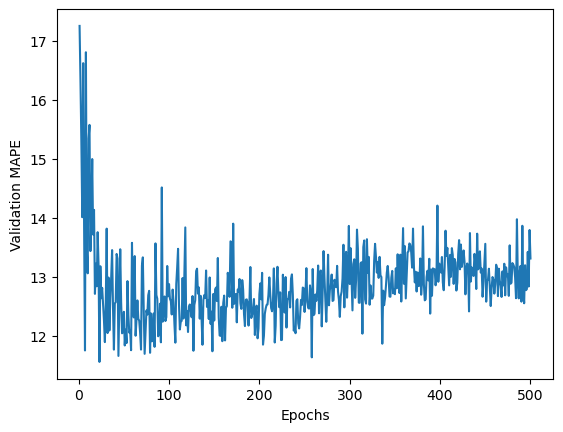

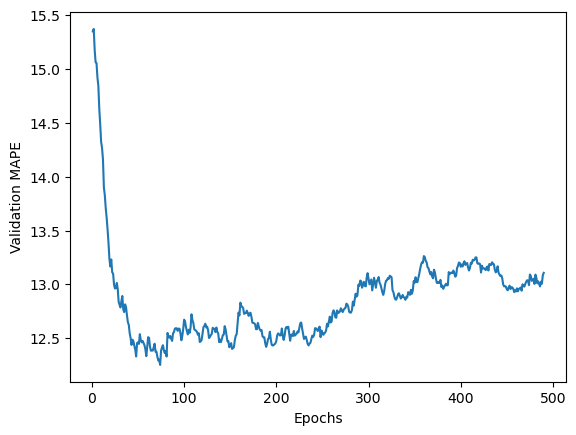

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4886 - mean_absolute_percentage_error: 10.9790
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.9332 - mean_absolute_percentage_error: 14.0582
train mape: 11.350817680358887
test mape: 15.330116271972656


In [7]:
import keras
keras.__version__

from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

mean = train_data.mean(axis=0) 
std = train_data.std(axis=0)

train_data -= mean
train_data /= std

test_data -= mean   # z-score data normalization
test_data /= std

from keras import models
from keras import layers
from keras import metrics

#建立神經網路模型
def build_model():
# Because we will need to instantiate
# the same model multiple times,
# we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_shape=(train_data.shape[1],))) #第一層，64個神經元，activation函數為relu/sigmoid/softplus
    model.add(layers.Dense(128, activation='relu')) #第二層，64個神經元，activation函數為relu/sigmoid/softplus
    model.add(layers.Dense(128, activation='relu')) #第三層，64個神經元，activation函數為relu/sigmoid/softplus
    model.add(layers.Dense(1)) #最後一層，輸出值(房價預測)
    #編譯模型，使用 RMSprop 優化器，MSE 作為損失函數，並計算績效 (mape)
    model.compile(optimizer='rmsprop', loss='mse', metrics=[metrics.mean_absolute_percentage_error])
    return model

import numpy as np
# 進行 K 折交叉驗證
k = 4
num_val_samples = len(train_data) // k #每折的資料數量
num_epochs = 100 #訓練週期數
all_scores = []
#驗證數據(第i折)
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
#準備訓練數據(不包含第 i 折的數據)
    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    # Build the Keras model (already compiled) 建立並訓練模型
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data 在驗證數據上評估模型
    val_mse, val_mape = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mape)

from keras import backend as K

# Some memory clean-up 釋放記憶體
K.clear_session()
# 進行更長時間的訓練並記錄 MAPE
num_epochs = 500
all_mape_histories = []

for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k 準備驗證數據(第 i 折)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partition 準備訓練數據(不包含第 i 折的數據)
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled) 建立並訓練模型
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mape_history = history.history['val_mean_absolute_percentage_error'] #記錄驗證集的績效 (RMSE)
    all_mape_histories.append(mape_history)

# 計算平均 績效(MAE) 變化情況
average_mape_history = [
    np.mean([x[i] for x in all_mape_histories]) for i in range(num_epochs)]

# 繪製驗證績效 (MAE) 曲線
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mape_history) + 1), average_mape_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAPE')
plt.show()

def smooth_curve(points, factor=0.9):
   # 平滑曲線，降低波動
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

# 平滑處理曲線
smooth_mape_history = smooth_curve(average_mape_history[10:])

plt.plot(range(1, len(smooth_mape_history) + 1), smooth_mape_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAPE')
plt.show()

# Get a fresh, compiled model. 使用完整的數據集重新訓練模型
model = build_model()
# Train it on the entirety of the data. 在測試集上評估模型
model.fit(train_data, train_targets,
          epochs=120, batch_size=32, verbose=0)
train_mape_score, train_mape_score = model.evaluate(train_data, train_targets)
test_mape_score, test_mape_score = model.evaluate(test_data, test_targets)
print('train mape:', train_mape_score)
print('test mape:', test_mape_score)